## Using NLP Methods to extract meaning from free text for supervised modelling 📜🗣️

### The data: Rent prices in Vienna, scraped previously from [Willhaben.at](https://www.willhaben.at)

In [1]:
# Load the necessary libraries
library(tidyverse)
library(tidytext)
library(broom)
library(lubridate)
library(tidymodels)
library(textrecipes)
library(vip)
library(doParallel)

# Chart Theme
theme_set(theme_bw() +
          theme(plot.title = element_text(size = 14, face = "bold"),
                plot.subtitle = element_text(size = 10, face = "italic",
                                             colour = "grey50")))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ dials        1.0.0     ✔ rsample      1.1.0
✔ infer        1.0.3     ✔ tune         1.0.1
✔ modeldata    1.0.1     ✔ workflows    1.1.0
✔ parsnip      1.0.2     ✔ workflowsets 1.0.0
✔ recipes      1.0.1     ✔ yardstick    1.1.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ r

In [2]:
# read in the data with some mods
data <- read_csv("C:/Users/mathi/OneDrive/Python/52-Weeks-of-Python-and-R-2023/08 - Tokenisation/Willhaben_everything_clean.csv") %>%
    filter(postcode != 9999) %>% 
    mutate(across(c(rooms, postcode, landlord), as.factor))

Rows: 7655 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): title, landlord
dbl (4): price, sqm, rooms, postcode

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
glimpse(data)

Rows: 7,652
Columns: 6
$ title    <chr> "Provisionsfreie 2-Zimmer Wohnung in Ober St. Veit, Erstbezug…
$ price    <dbl> 780.00, 795.00, 1114.47, 895.00, 1073.00, 799.40, 596.00, 950…
$ sqm      <dbl> 47, 43, 70, 48, 78, 46, 40, 66, 64, 58, 30, 223, 40, 421, 126…
$ rooms    <fct> 2, 2, 3, 2, 3, 2, 2, 2, 3, 3, 1, 6, 2, 8, 2, 2, 2, 3, 2, 2, 2…
$ postcode <fct> 1130, 1120, 1230, 1030, 1140, 1140, 1170, 1130, 1160, 1010, 1…
$ landlord <fct> "Privat", "Privat", "BUWOG Group GmbH", "Privat", "Privat", "…


Only one column has a little missing data:

In [4]:
colMeans(is.na(data)) %>% 
    enframe() %>% 
    arrange(-value) %>% 
    filter(value > 0)

name,value
<chr>,<dbl>
rooms,0.009670674


German stopwords:

In [21]:
german_stopwords <- c(
    "aber", "alle", "allem", "allen",
    "aller", "alles", "als", "also", "am", "an", "ander", "andere",
    "anderem", "anderen", "anderer", "anderes", "anderm", "andern",
    "anderr", "anders", "auch", "auf", "aus", "bei", "bin", "bis",
    "bist", "da", "damit", "dann", "der", "den", "des", "dem", "die",
    "das", "dass", "daß", "derselbe", "derselben", "denselben", "desselben",
    "demselben", "dieselbe", "dieselben", "dasselbe", "dazu", "dein",
    "deine", "deinem", "deinen", "deiner", "deines", "denn", "derer",
    "dessen", "dich", "dir", "du", "dies", "diese", "diesem", "diesen",
    "dieser", "dieses", "doch", "dort", "durch", "ein", "eine", "einem",
    "einen", "einer", "eines", "einig", "einige", "einigem", "einigen",
    "einiger", "einiges", "einmal", "er", "ihn", "ihm", "es", "etwas",
    "euer", "eure", "eurem", "euren", "eurer", "eures", "für", "gegen", "gewesen",
    "hab", "habe", "haben", "hat", "hatte", "hatten", "hier", "hin", "hinter",
    "ich", "mich", "mir", "ihr", "ihre", "ihrem", "ihren", "ihrer", "ihres", "euch",
    "im", "in", "indem", "ins", "ist", "jede", "jedem", "jeden", "jeder",
    "jedes", "jene", "jenem", "jenen", "jener", "jenes", "jetzt",
    "kann", "kein", "keine", "keinem", "keinen", "keiner", "keines", "können",
    "könnte", "machen", "man", "manche", "manchem", "manchen", "mancher", "manches", "mein",
    "meine", "meinem", "meinen", "meiner", "meines", "mit", "muss", "musste",
    "nach", "nicht", "nichts", "noch", "nun", "nur", "ob", "oder", "ohne",
    "sehr", "sein", "seine", "seinem", "seinen", "seiner", "seines", "selbst",
    "sich", "sie", "ihnen", "sind", "so", "solche", "solchem", "solchen", "solcher",
    "solches", "soll", "sollte", "sondern", "sonst", "über", "um", "und",
    "uns", "unsere", "unserem", "unseren", "unser", "unseres", "unter", "viel",
    "vom", "von", "vor", "während", "war", "waren", "warst", "was", "weg",
    "weil", "weiter", "welche", "welchem", "welchen", "welcher", "welches", "wenn",
    "werde", "werden", "wie", "wieder", "will", "wir", "wird", "wirst",
    "wo", "wollen", "wollte", "würde", "würden", "zu", "zum", "zur",
    "zwar", "zwischen"
)

### Training a Model

Firstly: Making the splits and folds for cross validated hyperparameter tuning.

In [5]:
dt_split <- initial_split(data)
dt_train <- training(dt_split)
dt_test <- testing(dt_split)

folds <- vfold_cv(dt_train, folds=5)

Then, providing two recipes, one with tokenisation and stopword removal and one without.

In [22]:
recipe_withtokens <- recipe(price ~ ., data = dt_train) %>%
    step_unknown(rooms) %>%
    step_tokenize(title) %>%
    step_stopwords(title,
        custom_stopword_source = german_stopwords
    ) %>%
    step_tokenfilter(title, max_tokens = 100) %>%
    step_tf(title) %>%
    step_other(all_nominal_predictors(), threshold = 0.01) %>%
    step_dummy(all_nominal_predictors(), one_hot = TRUE)

recipe_notokens <- recipe(price ~ ., data = dt_train) %>%
    step_unknown(rooms) %>%
    step_rm(title) %>%
    step_other(all_nominal_predictors(), threshold = 0.01) %>%
    step_dummy(all_nominal_predictors(), one_hot = TRUE)

In [24]:
recipe_withtokens %>% prep %>% juice %>% glimpse

Rows: 5,739
Columns: 146
$ sqm                                               <dbl> 71, 45, 79, 49, 38, …
$ price                                             <dbl> 1120.00, 789.81, 420…
$ tf_title_1                                        <dbl> 0, 0, 1, 1, 0, 0, 1,…
$ tf_title_2                                        <dbl> 1, 1, 0, 0, 0, 0, 0,…
$ tf_title_3                                        <dbl> 0, 0, 0, 0, 0, 0, 0,…
$ tf_title_4                                        <dbl> 0, 0, 0, 0, 1, 0, 1,…
$ tf_title_ab                                       <dbl> 0, 0, 0, 0, 0, 0, 0,…
$ tf_title_aktion                                   <dbl> 0, 0, 0, 1, 0, 0, 0,…
$ tf_title_altbau                                   <dbl> 0, 0, 0, 0, 0, 0, 0,…
$ tf_title_altbauwohnung                            <dbl> 0, 0, 0, 0, 0, 0, 0,…
$ tf_title_anfragen                                 <dbl> 0, 0, 0, 0, 0, 0, 0,…
$ tf_title_apartment                                <dbl> 0, 0, 0, 0, 0, 0, 0,…
$ tf_title_aufs

Setting up the model specification:

In [25]:
gb_spec <- 
  boost_tree(
    trees = 1000,
    tree_depth = tune(),
    min_n = tune(),
    loss_reduction = tune(),
    sample_size = tune(),
    mtry = tune(),
    learn_rate = tune()
  ) %>%
  set_engine("xgboost", importance = "impurity") %>%
  set_mode("regression")

Setting up the workflows. One with tokenisation and one without.

In [26]:
gb_wflow_notokens <- workflow() %>%
    add_recipe(recipe_notokens,
        blueprint = hardhat::default_recipe_blueprint(
            allow_novel_levels = TRUE
        )
    ) %>%
    add_model(gb_spec)

gb_wflow_withtokens <- workflow() %>%
    add_recipe(recipe_withtokens,
        blueprint = hardhat::default_recipe_blueprint(
            allow_novel_levels = TRUE
        )
    ) %>%
    add_model(gb_spec)

In [27]:
gb_wflow_withtokens

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: boost_tree()

── Preprocessor ────────────────────────────────────────────────────────────────
7 Recipe Steps

• step_unknown()
• step_tokenize()
• step_stopwords()
• step_tokenfilter()
• step_tf()
• step_other()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────
Boosted Tree Model Specification (regression)

Main Arguments:
  mtry = tune()
  trees = 1000
  min_n = tune()
  tree_depth = tune()
  learn_rate = tune()
  loss_reduction = tune()
  sample_size = tune()

Engine-Specific Arguments:
  importance = impurity

Computational engine: xgboost 


Providing a grid of hyperparameter values to be tuned through.

In [28]:
gb_grid <- 
  grid_latin_hypercube(
    tree_depth(),
    min_n(),
    loss_reduction(),
    sample_size = sample_prop(),
    finalize(mtry(), dt_train),
    learn_rate(),
    size = 15
  )

glimpse(gb_grid)

Rows: 15
Columns: 6
$ tree_depth     <int> 13, 8, 12, 5, 2, 3, 3, 11, 6, 10, 12, 15, 8, 4, 9
$ min_n          <int> 33, 25, 32, 16, 28, 8, 3, 15, 10, 22, 39, 18, 23, 5, 36
$ loss_reduction <dbl> 1.508804e-04, 1.030452e-08, 7.587773e-06, 1.102988e-06,…
$ sample_size    <dbl> 0.5989820, 0.4559255, 0.6419281, 0.7880331, 0.2377450, …
$ mtry           <int> 2, 1, 3, 3, 1, 4, 5, 3, 5, 6, 2, 6, 4, 5, 3
$ learn_rate     <dbl> 3.455905e-07, 1.621309e-05, 1.883798e-02, 1.908520e-04,…


### Hyperparameter Tuning without Tokens

Using 6 cores for the tuning process:

In [29]:
start_time <- Sys.time()

unregister_dopar <- function() {
    env <- foreach:::.foreachGlobals
    rm(list = ls(name = env), pos = env)
}

cl <- makePSOCKcluster(6)
registerDoParallel(cl)

gb_tune_notokens <- tune_grid(
    object = gb_wflow_notokens,
    resamples = folds,
    grid = gb_grid
)

stopCluster(cl)
unregister_dopar()

end_time <- Sys.time()
end_time - start_time

Time difference of 2.55962 mins

### Hyperparameter Tuning with Tokens

In [30]:
start_time <- Sys.time()

unregister_dopar <- function() {
    env <- foreach:::.foreachGlobals
    rm(list = ls(name = env), pos = env)
}

cl <- makePSOCKcluster(6)
registerDoParallel(cl)

gb_tune_withtokens <- tune_grid(
    object = gb_wflow_withtokens,
    resamples = folds,
    grid = gb_grid
)

stopCluster(cl)
unregister_dopar()

end_time <- Sys.time()
end_time - start_time

Time difference of 4.490944 mins

### Fitting the final models as the best combinations of hyperparameters from the tuning process

This you don't need to do in `sklearn` after doing a grid search.

In [31]:
gb_final_fit_notokens <- gb_wflow_notokens %>%
    finalize_workflow(select_best(gb_tune_notokens, metric = "rmse")) %>%
    last_fit(dt_split)

gb_final_fit_withtokens <- gb_wflow_withtokens %>%
    finalize_workflow(select_best(gb_tune_withtokens, metric = "rmse")) %>%
    last_fit(dt_split)

### Evaluating performance of the two models

In [32]:
eval_metrics <- metric_set(rsq, mae, rmse, mape)

In [33]:
gb_final_fit_notokens %>% 
    collect_predictions() %>% 
    eval_metrics(truth = price, estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.6761958
mae,standard,165.9308253
rmse,standard,379.2683235
mape,standard,15.0627504


In [34]:
gb_final_fit_withtokens %>% 
    collect_predictions() %>% 
    eval_metrics(truth = price, estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7013132
mae,standard,169.7903552
rmse,standard,361.3285651
mape,standard,15.9378967


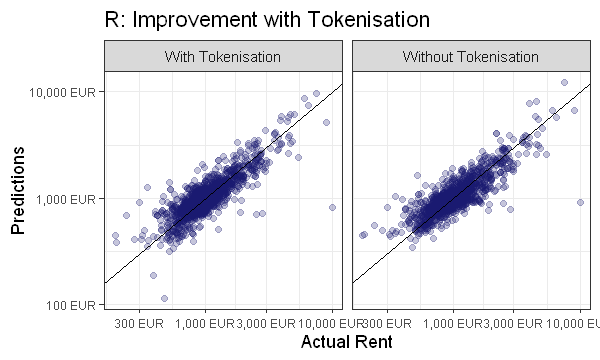

In [39]:
options(repr.plot.width = 5, repr.plot.height = 3)

bind_rows(
    gb_final_fit_notokens %>%
        collect_predictions() %>% 
        mutate(model = "Without Tokenisation"),
    gb_final_fit_withtokens %>%
        collect_predictions() %>% 
        mutate(model = "With Tokenisation")
) %>%
    filter(price > 100) %>% 
    ggplot(aes(x = price, y = .pred)) +
    geom_point(alpha = 0.25, colour = "midnightblue") +
    geom_abline() +
    labs(
        title = "R: Improvement with Tokenisation",
        x = "Actual Rent", y = "Predictions"
    ) +
    facet_wrap(~model) +
    scale_y_log10(labels = comma_format(suffix = " EUR")) +
    scale_x_log10(labels = comma_format(suffix = " EUR")) +
    theme_bw() +
    theme(axis.text = element_text(size = 7))

In [40]:
ggsave(file = "R.png", dpi = 300, width = 4, height = 2.5)